In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score
from ahu_model import fan_power_from_speed

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
fan_data = pd.read_csv('fan_data.csv')
# Change the name of the speed_column ratio to hz
fan_data.rename(columns={'speed_ratio': 'speed_hertz'}, inplace=True)
# Add a new column, speed_ratio, which is the normalized speed_hertz bertween 0 and 1
fan_data['speed_ratio'] = fan_data['speed_hertz'] / fan_data['speed_hertz'].max()

In [3]:
fan_data.describe()

,speed_hertz,kW,speed_ratio
count,35040.000000,35040.000000,35040.000000
mean,7.995435,0.164545,0.136418
std,15.727502,0.384702,0.268342
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,58.610000,2.470000,1.000000


In [4]:
# Any null values?
fan_data.isnull().sum()

speed_hertz    0
kW             0
speed_ratio    0
dtype: int64

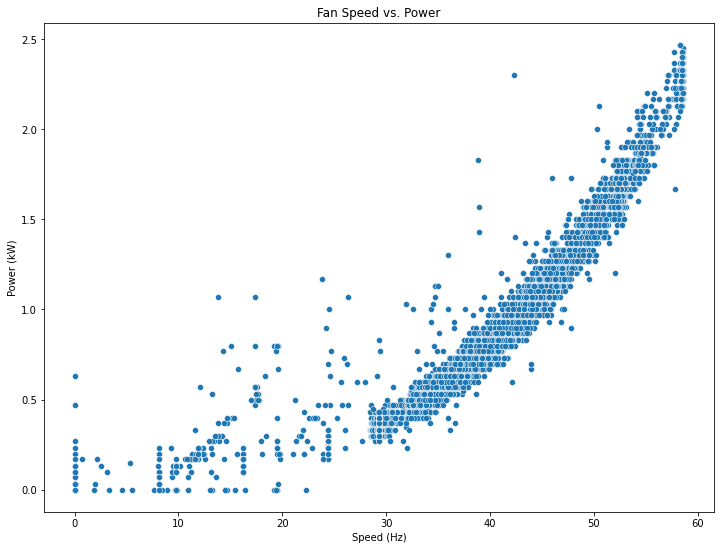

<Figure size 864x648 with 0 Axes>

In [19]:
# Graph the data
p = sns.scatterplot(x='speed_hertz', y='kW', data=fan_data)
p.set_xlabel("Speed (Hz)")
p.set_ylabel("Power (kW)")
p.set_title("Fan Speed vs. Power")
plt.show()

In [6]:
# Fit a cubic polynomial constrained so that the intercept is 0
def cubic_poly(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# the x data is the valid speed ratios
x = fan_data['speed_ratio']
# the y data is the valid power values
y = fan_data['kW']

# Fit the data
initial_fit = curve_fit(cubic_poly, x, y)

# Round the coefficients to 5 decimal places
a = round(initial_fit[0][0], 5)
b = round(initial_fit[0][1], 5)
c = round(initial_fit[0][2], 5)
d = round(initial_fit[0][3], 5)

# Print the polynomial coefficients
print("The cubic polynomial is:")
print("y = " + str(a) + "x^3 + " + str(b) + "x^2 + " + str(c) + "x + " + str(d))

The cubic polynomial is:
y = 2.77705x^3 + -1.10228x^2 + 0.63502x + 0.00028


In [7]:
# Assume that when speed = 0, power = 0. Speed requires power, and power requires speed.
# Add a new column, outliers, which is a boolean value indicating if the data point is an outlier
fan_data['invalid'] = fan_data.apply(lambda row: True if (row['speed_ratio'] == 0 and row['kW'] != 0) or (row['speed_ratio'] != 0 and row['kW'] == 0) else False, axis=1)

Text(0.5, 1.0, 'Fan Speed vs. Power')

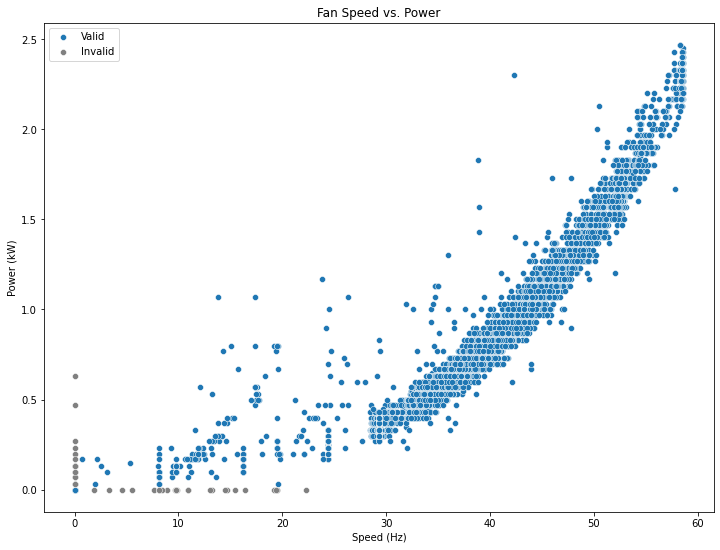

In [8]:
# Plot the outlier data
p = sns.scatterplot(x='speed_hertz', y='kW', data=fan_data[fan_data['invalid'] == False])
# Plot the non-outlier data on top
p = sns.scatterplot(x='speed_hertz', y='kW', data=fan_data[fan_data['invalid'] == True], color='grey')
p.legend(['Valid', 'Invalid'])
p.set_xlabel("Speed (Hz)")
p.set_ylabel("Power (kW)")
p.set_title("Fan Speed vs. Power")

In [9]:
# Fit a cubic polynomial constrained so that the intercept is 0
def cubic_poly(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# the x data is the valid speed ratios
x = fan_data['speed_ratio'][fan_data['invalid'] == False]
# the y data is the valid power values
y = fan_data['kW'][fan_data['invalid'] == False]

# Fit the data
constrained_fit = curve_fit(cubic_poly, x, y, bounds=([-np.inf, -np.inf, -np.inf, -0.000001], [np.inf, np.inf, np.inf, 0.000001]))

# Round the coefficients to 5 decimal places
a = round(constrained_fit[0][0], 5)
b = round(constrained_fit[0][1], 5)
c = round(constrained_fit[0][2], 5)
d = round(constrained_fit[0][3], 5)

# Print the polynomial coefficients
print("The cubic polynomial is:")
print("y = " + str(a) + "x^3 + " + str(b) + "x^2 + " + str(c) + "x + " + str(d))

The cubic polynomial is:
y = 2.81955x^3 + -1.16552x^2 + 0.65804x + 0.0


In [10]:
# calculate the spread of the data in kW at each speed
fan_data['spread'] = fan_data.apply(lambda row: abs(row['kW'] - cubic_poly(row['speed_ratio'], *constrained_fit[0])), axis=1)

In [11]:
# Get the average spread value at each unique speed_ratio and convert to dict
avg_spread = fan_data.groupby('speed_ratio').mean()['spread'].to_dict()
fan_data['upper_fake'] = fan_data.apply(lambda row: row['kW'] + 8*avg_spread[row['speed_ratio']], axis=1)
fan_data['lower_fake'] = fan_data.apply(lambda row: row['kW'] - 5.5*avg_spread[row['speed_ratio']], axis=1)

# Fit a cubic polynomial for the upper fake data
upper_bound_fit = curve_fit(cubic_poly, x, fan_data[fan_data['invalid'] == False]['upper_fake'])
# Fit a cubic polynomial for the lower fake data
lower_bound_fit = curve_fit(cubic_poly, x, fan_data[fan_data['invalid'] == False]['lower_fake'])



Text(0.5, 1.0, 'Fan Speed vs. Power')

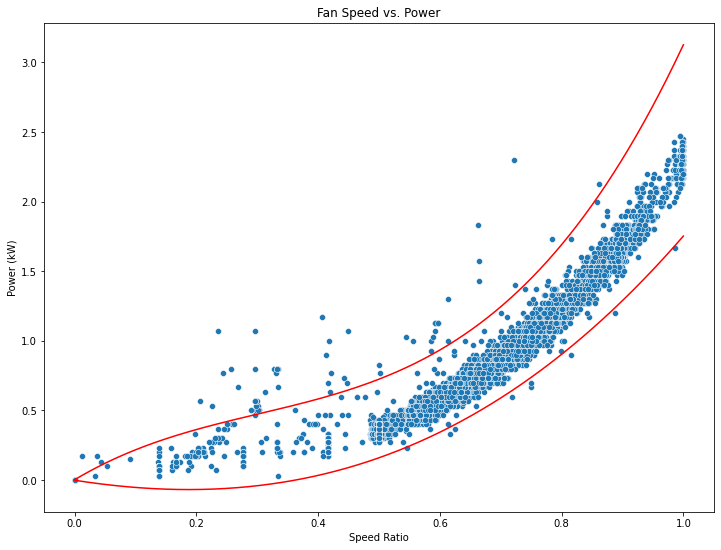

In [12]:
# Plot the data and the fits
p = sns.scatterplot(x='speed_ratio', y='kW', data=fan_data[fan_data['invalid'] == False])
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *upper_bound_fit[0]), color='red')
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *lower_bound_fit[0]), color='red')
p.set_xlabel("Speed Ratio")
p.set_ylabel("Power (kW)")
p.set_title("Fan Speed vs. Power")


In [13]:
# If a data point is above the upper bound, or below the lower bound, it is an outlier
fan_data['invalid'] = fan_data.apply(lambda row: True if row['kW'] > cubic_poly(row['speed_ratio'], *upper_bound_fit[0]) or row['kW'] < cubic_poly(row['speed_ratio'], *lower_bound_fit[0]) else row['invalid'], axis=1)

Text(0.5, 1.0, 'Fan Speed vs. Power')

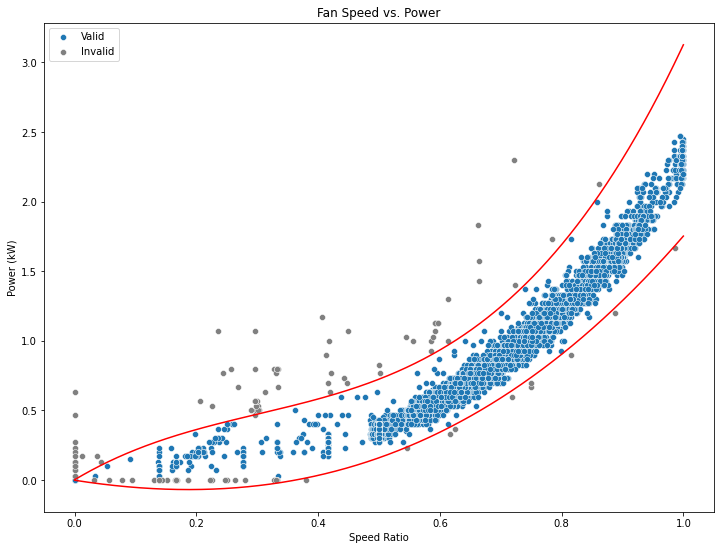

In [14]:
# Plot the outlier data
p = sns.scatterplot(x='speed_ratio', y='kW', data=fan_data[fan_data['invalid'] == False])
# Plot the non-outlier data on top
p = sns.scatterplot(x='speed_ratio', y='kW', data=fan_data[fan_data['invalid'] == True], color='grey')
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *upper_bound_fit[0]), color='red')
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *lower_bound_fit[0]), color='red')
p.legend(['Valid', 'Invalid'])
p.set_xlabel("Speed Ratio")
p.set_ylabel("Power (kW)")
p.set_title("Fan Speed vs. Power")

In [15]:
# Fit a cubic polynomial constrained so that the intercept is 0 on the valid data
# the x data is the valid speed ratios
x = fan_data[fan_data['invalid'] == False]['speed_ratio']
# the y data is the valid power values
y = fan_data[fan_data['invalid'] == False]['kW']

# Fit the data
constrained_fit_final = curve_fit(cubic_poly, x, y, bounds=([-np.inf, -np.inf, -np.inf, -0.000001], [np.inf, np.inf, np.inf, 0.000001]))

# Round the coefficients to 5 decimal places
a = round(constrained_fit_final[0][0], 5)
b = round(constrained_fit_final[0][1], 5)
c = round(constrained_fit_final[0][2], 5)
d = round(constrained_fit_final[0][3], 5)

# Print the polynomial coefficients
print("The cubic polynomial is:")
print("y = " + str(a) + "x^3 + " + str(b) + "x^2 + " + str(c) + "x + " + str(d))

The cubic polynomial is:
y = 2.63482x^3 + -0.87385x^2 + 0.54521x + 0.0


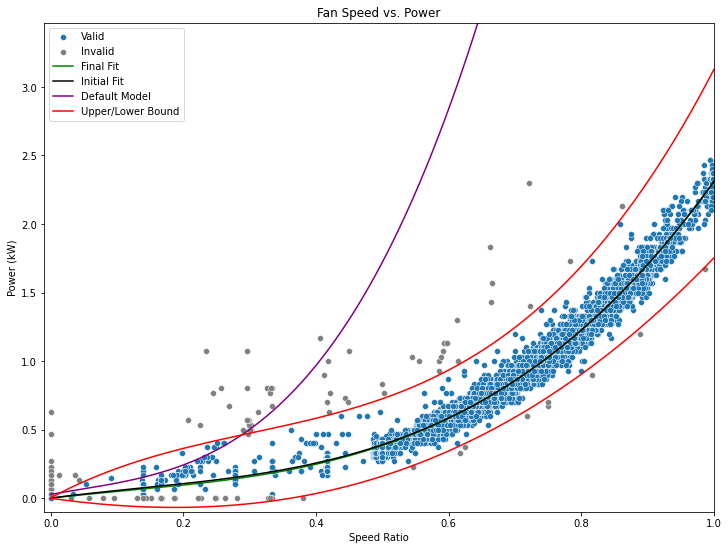

In [26]:
# Plot the outlier data
p = sns.scatterplot(x='speed_ratio', y='kW', data=fan_data[fan_data['invalid'] == False])
# Plot the non-outlier data on top
p = sns.scatterplot(x='speed_ratio', y='kW', data=fan_data[fan_data['invalid'] == True], color='grey')
# Plot the constrained fit on top and the constrained_fit_final on top
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *constrained_fit_final[0]), color='green')
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *initial_fit[0]), color='black')
# Plot the deafault model given in ahu_model.py on top
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=fan_power_from_speed(np.linspace(0, 1, 10000)), color='purple')
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *upper_bound_fit[0]), color='red')
p = sns.lineplot(x=np.linspace(0, 1, 10000), y=cubic_poly(np.linspace(0, 1, 10000), *lower_bound_fit[0]), color='red')
p.legend(['Valid', 'Invalid', 'Final Fit', 'Initial Fit', 'Default Model', 'Upper/Lower Bound'])
p.set_xlabel("Speed Ratio")
p.set_ylabel("Power (kW)")
p.set_title("Fan Speed vs. Power")
p.set_xlim(-.01, 1)
p.set_ylim(-.1, max(fan_data['kW']) + 1)
plt.show()

In [29]:
# Determine the coefficient of determination for the final constrained fit on the valid data
r_squared_final = r2_score(fan_data[fan_data['invalid'] == False]['kW'], cubic_poly(fan_data[fan_data['invalid'] == False]['speed_ratio'], *constrained_fit_final[0]))
# Determine the coefficient of determination for the initial fit on the valid data
r_squared_initial = r2_score(fan_data[fan_data['invalid'] == False]['kW'], cubic_poly(fan_data[fan_data['invalid'] == False]['speed_ratio'], *initial_fit[0]))
# Determine the coefficient of determination for the default model on the valid data
r_squared_default = r2_score(fan_data[fan_data['invalid'] == False]['kW'], fan_power_from_speed(fan_data[fan_data['invalid'] == False]['speed_ratio']))

print("The coefficient of determination for the final constrained fit is:")
print(round(r_squared_final, 5))
print("The coefficient of determination for the initial fit is:")
print(round(r_squared_initial, 5))
print("The coefficient of determination for the default model is:")
print(round(r_squared_default, 5))

The coefficient of determination for the final constrained fit is:
0.99423
The coefficient of determination for the initial fit is:
0.99419
The coefficient of determination for the default model is:
-20.10609
